### Makemore Part 3: MLP with Optimizations

#### Optimize Initial Loss

A naive way to initialize a network is to randomly assign the probability of one character
following another. This can lead to a high initial loss and then once the network starts to
train there will be a dramatic drop.

A better way to do this intiialization would be to assign the probabilty of one character
following another would be to assign them all a uniform likelihood. For instance, for our 27
characters, each character will start off with a 1/27 probability.

The effect this has on the neural network is that the network spends more time optimizing the
network rather than squashing the weights down to a point at which loss optimization can begin

#### Fixing Saturated `tanh`

...

In [6]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
block_size = 3 # context length: how many characters do we take to predict the next one?

In [10]:
# build the dataset
def build_dataset(words, label=''):
  X, Y = [], [] # inputs, labels
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append (rolling window of context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(label, X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1], label='train')
X_val, Y_val = build_dataset(words[n1:n2], label='validation')
X_test, Y_test = build_dataset(words[n2:], label='test')

train torch.Size([182625, 3]) torch.Size([182625])
validation torch.Size([22655, 3]) torch.Size([22655])
test torch.Size([22866, 3]) torch.Size([22866])


In [32]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden,), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [33]:
# optimzation
max_steps = 200_000
batch_size = 32
losses = []
steps = []
for i in range(max_steps):
    # batch construction
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embeded the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hp_react = emb_cat @ W1 + b1 # hidden layer
    h = torch.tanh(hp_react) # activation of hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    steps.append(i)

      0/ 200000: 4.2326
  10000/ 200000: 2.1403
  20000/ 200000: 2.4720
  30000/ 200000: 2.5577
  40000/ 200000: 2.0154
  50000/ 200000: 2.4307
  60000/ 200000: 2.3385
  70000/ 200000: 2.0680
  80000/ 200000: 2.2665
  90000/ 200000: 2.1172
 100000/ 200000: 1.9299
 110000/ 200000: 2.0630
 120000/ 200000: 1.8901
 130000/ 200000: 2.3980
 140000/ 200000: 2.2826
 150000/ 200000: 2.1250
 160000/ 200000: 1.8469
 170000/ 200000: 1.7628
 180000/ 200000: 1.9119
 190000/ 200000: 1.8235


In [25]:
# A naive way to initialize a network is to randomly assign the probability of one character
# following another. This can lead to a high initial loss and then once the network starts to
# train there will be a dramatic drop.
#
# A better way to do this intiialization would be to assign the probabilty of one character
# following another would be to assign them all a uniform likelihood. For instance, for our 27
# characters, each character will start off with a 1/27 probability.
#
# The effect this has on the neural network is that the network spends more time optimizing the
# network rather than squashing the weights down to a point at which loss optimization can begin
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [26]:
# 4 dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

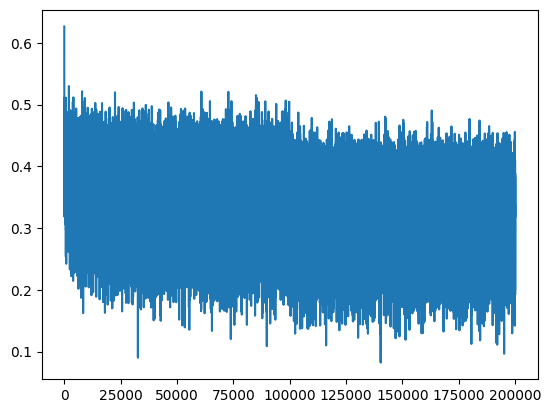

In [34]:
plt.plot(steps, losses)

In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    # setup
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]

    # forward pass
    emb = C[x] # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size, n_embd)
    h = torch.tanh(emb_cat @ W1 + b1) # (N, hidden_size)
    logits = h @ W2 + b2 # (N, vocab_size)

    # eval
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0681495666503906
val 2.132511854171753


In [22]:
# Sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all '...'
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amille.
khy.
mili.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nextara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.
